## Librerias Necesarias

In [1]:

import numpy as np
import CPMP_attention_model as cpmp_att

## Funciones para entrenamiento y predicciones

In [2]:
#************ | expand_dims_cpmp() | **************#
# El proposito de esta función es expandir las     #
# dimensiones de un estado menor para que pueda    #
# ser predicho un por modelo para un estado mayor. #
#                                                  #
# Input:                                           #
#     - data: Lista de matrices con todos los      #
#             estados.                             #
#     - labels: lista de posibles stacks de origen #
#               o destino.                         #
#     - stacks: Cantidad de stacks permitidos por  #    
#               el modelo.                         #
#     - height: Altura máxima de los stacks        #
#               permitidos por el modelo.          #
#                                                  #
# Output:                                          #
#      Retona un arreglo de los datos              #
#      redimensionados con sus respectivos labels. #
def expand_dims_cpmp(data, labels, stacks, height):
    size = data.shape[1]
    tuple_data = zip(data, labels)
    data_2 = []
    labels_2 = []

    for matrix, label in tuple_data:
        matrix = matrix.tolist()
        label = label.tolist()
        for i in range(stacks - size):
            matrix.append([1] + [1 for n in range(height)])
            label.append(0)

        data_2.append(matrix)
        labels_2.append(label)

    return np.array(data_2), np.array(labels_2)

In [3]:
#*************** | concatenate_state_with_output() | ****************#
# El proposito de esta función es concatenar la data de las estados  #
# del problema con sus respectivos labels que indican el stack de    #
# origen.                                                            #
#                                                                    #
# Input:                                                             #
#     - states: Lista de matrices indicando los diversos estados.    #
#     - outputs: Lista de stacks de origen.                          #
#                                                                    #
# Output:                                                            # 
#      Retorna un arreglo con los datos concatenados.                #
def concatenate_state_with_output(states, outputs):
    size_stacks = len(states[0])
    size_height = len(states[0][0])
    tuple_data = zip(states, outputs)
    new_data = []

    for state, output in tuple_data:
        new_data.append([])

        for i in range(size_stacks):
            stack = state[i].tolist()
            stack.append(output[i])
            new_data[len(new_data) - 1].append(stack)

    return np.stack(new_data)

In [4]:
#************* | is_equal() | **************#
# El proposito de esta función es verificar #
# si los datos ingresados en dos arreglos   #
# son exactamente iguales independiente de  #
# su posición.                              #
#                                           #
# Input:                                    #
#     - array1: Primer arreglo que se       #
#               desea comparar.             #
#     - array2: Segundo arreglo que se      #
#               desea comparar.             #
# Output:                                   #
#     Retorna true en el caso de tener      #
#     cada dato exactamente igual o         #
#     False en caso contrario.              #
def is_equal(array1, array2):
    size = len(array1)
    cant = 0
    array1.sort()
    array2.sort()

    for i in range(size):
        if array1[i] == array2[i]:
            cant += 1

    if cant == size: return True

    return False

In [5]:
#***************** | precision() | ***************#
# El proposito de esta función es verificar si    #
# los valores predichos por una red neuronal son  #
# correctos o no.                                 #
#                                                 #
# Input:                                          #
#     - y_predict: Valores predichos por el       #
#                  mecanismo de machine learning. #
#     - y_test: Valores reales de los casos       #
#               predichos.                        #
# Output:                                         #
#     Retorna una proporción entre los valores    #
#     predichos correctamente sobre la cantidad   #
#     de datos.                                   #
def precision(y_predict, y_test):
    size = len(y_predict)
    predict = 0

    for i in range(size):
        if np.argmax(y_predict[i]) == np.argmax(y_test[i]):
            predict += 1
    
    return predict / size

In [6]:
#************** | precision_for_multiclass() | ***************#
# El proposito de esta función es verificar si los valores    #
# predichos por un mecanismo de machine learning para         #
# clasificación multiclase están correctos o no.              #
#                                                             # 
# Input:                                                      #
#     - y_predict: Valores predichos por el mecanismo de      #
#                  machine learning.                          #
#     - y_test: Valores reales de cada caso.                  #
# Output:                                                     #
#     Retorna una proporción entre los valores predichos      #
#     correctamente sobre la cantidad total de casos.         #
def precision_for_multiclass(y_predict, y_test):
    size = len(y_predict)
    predict = 0

    for i in range(size):
        cant_sol = np.count_nonzero(y_test[i] == 1.)
        
        indices_test = np.argsort(y_test[i])
        indices_test = indices_test[-cant_sol:]
        indices_predict = np.argsort(y_predict[i])
        indices_predict = indices_predict[-cant_sol:]

        if is_equal(indices_test, indices_predict):
            predict += 1
    
    return predict / size

## Funciones para cargar y guardar data

In [7]:
#************** | load_data() | ************#
# El proposito de esta función es cargar    #
# los datos almacenados en un csv para el   #
# entrenamiento de la red neuronal.         #
#                                           #
# Input:                                    #
#     - name: Nombre del archivo con su     #
#             dirección correspondiente     #
#             sin el .csv.                  #
#                                           #
# Output:                                   #
#      Retorna 3 arreglos, el primero       #
#      corresponde a una lista de estados,  #
#      el segundo a una lista de labels     #
#      de stacks de origen y por último una #
#      lista de posibles stacks de destino. #
def load_data(name):
    data = []
    labels_1 = []
    labels_2 = []

    with open(name + '.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)
            label_2 = archivo.readline().split(':')[1].split(',')
            label_2 = np.array(label_2, dtype= float)

            data.append(matrix)
            labels_1.append(label_1)
            labels_2.append(label_2)

            archivo.readline()

    return np.stack(data), np.stack(labels_1), np.stack(labels_2)

In [8]:
def load_data_multi(name):
    data = []
    data_2 = []
    labels_1 = []
    labels_2 = []

    with open(name + '_so.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)

            data.append(matrix)
            labels_1.append(label_1)

            archivo.readline()

    with open(name + '_sd.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_2 = archivo.readline().split(':')[1].split(',')
            label_2 = np.array(label_2, dtype= float)

            data_2.append(matrix)
            labels_2.append(label_2)

            archivo.readline()

    return np.stack(data), np.stack(data_2), np.stack(labels_1), np.stack(labels_2)

# Cargar Data

In [9]:
data_7x7, labels_1_7x7, labels_2_7x7 = load_data('data/data_7x7')

In [10]:
data_5x5, labels_1_5x5, labels_2_5x5 = load_data('data/data_5x5')

In [11]:
data_5x5_multi, labels_1_5x5_multi, labels_2_5x5_multi = load_data('data/data_5x5_SO_Multiple_alpha')

# Modelo con Varias Salidas

## Modelo 5x5

In [9]:
model_5x5_multi = cpmp_att.CPMP_attention_model()
model_5x5_multi.create_model(num_layer_attention_add_so= 2, num_layer_attention_add_sd= 2, heads_so= 5, heads_sd= 5,
                             S= 5, H= 5, optimizer= 'Adam')

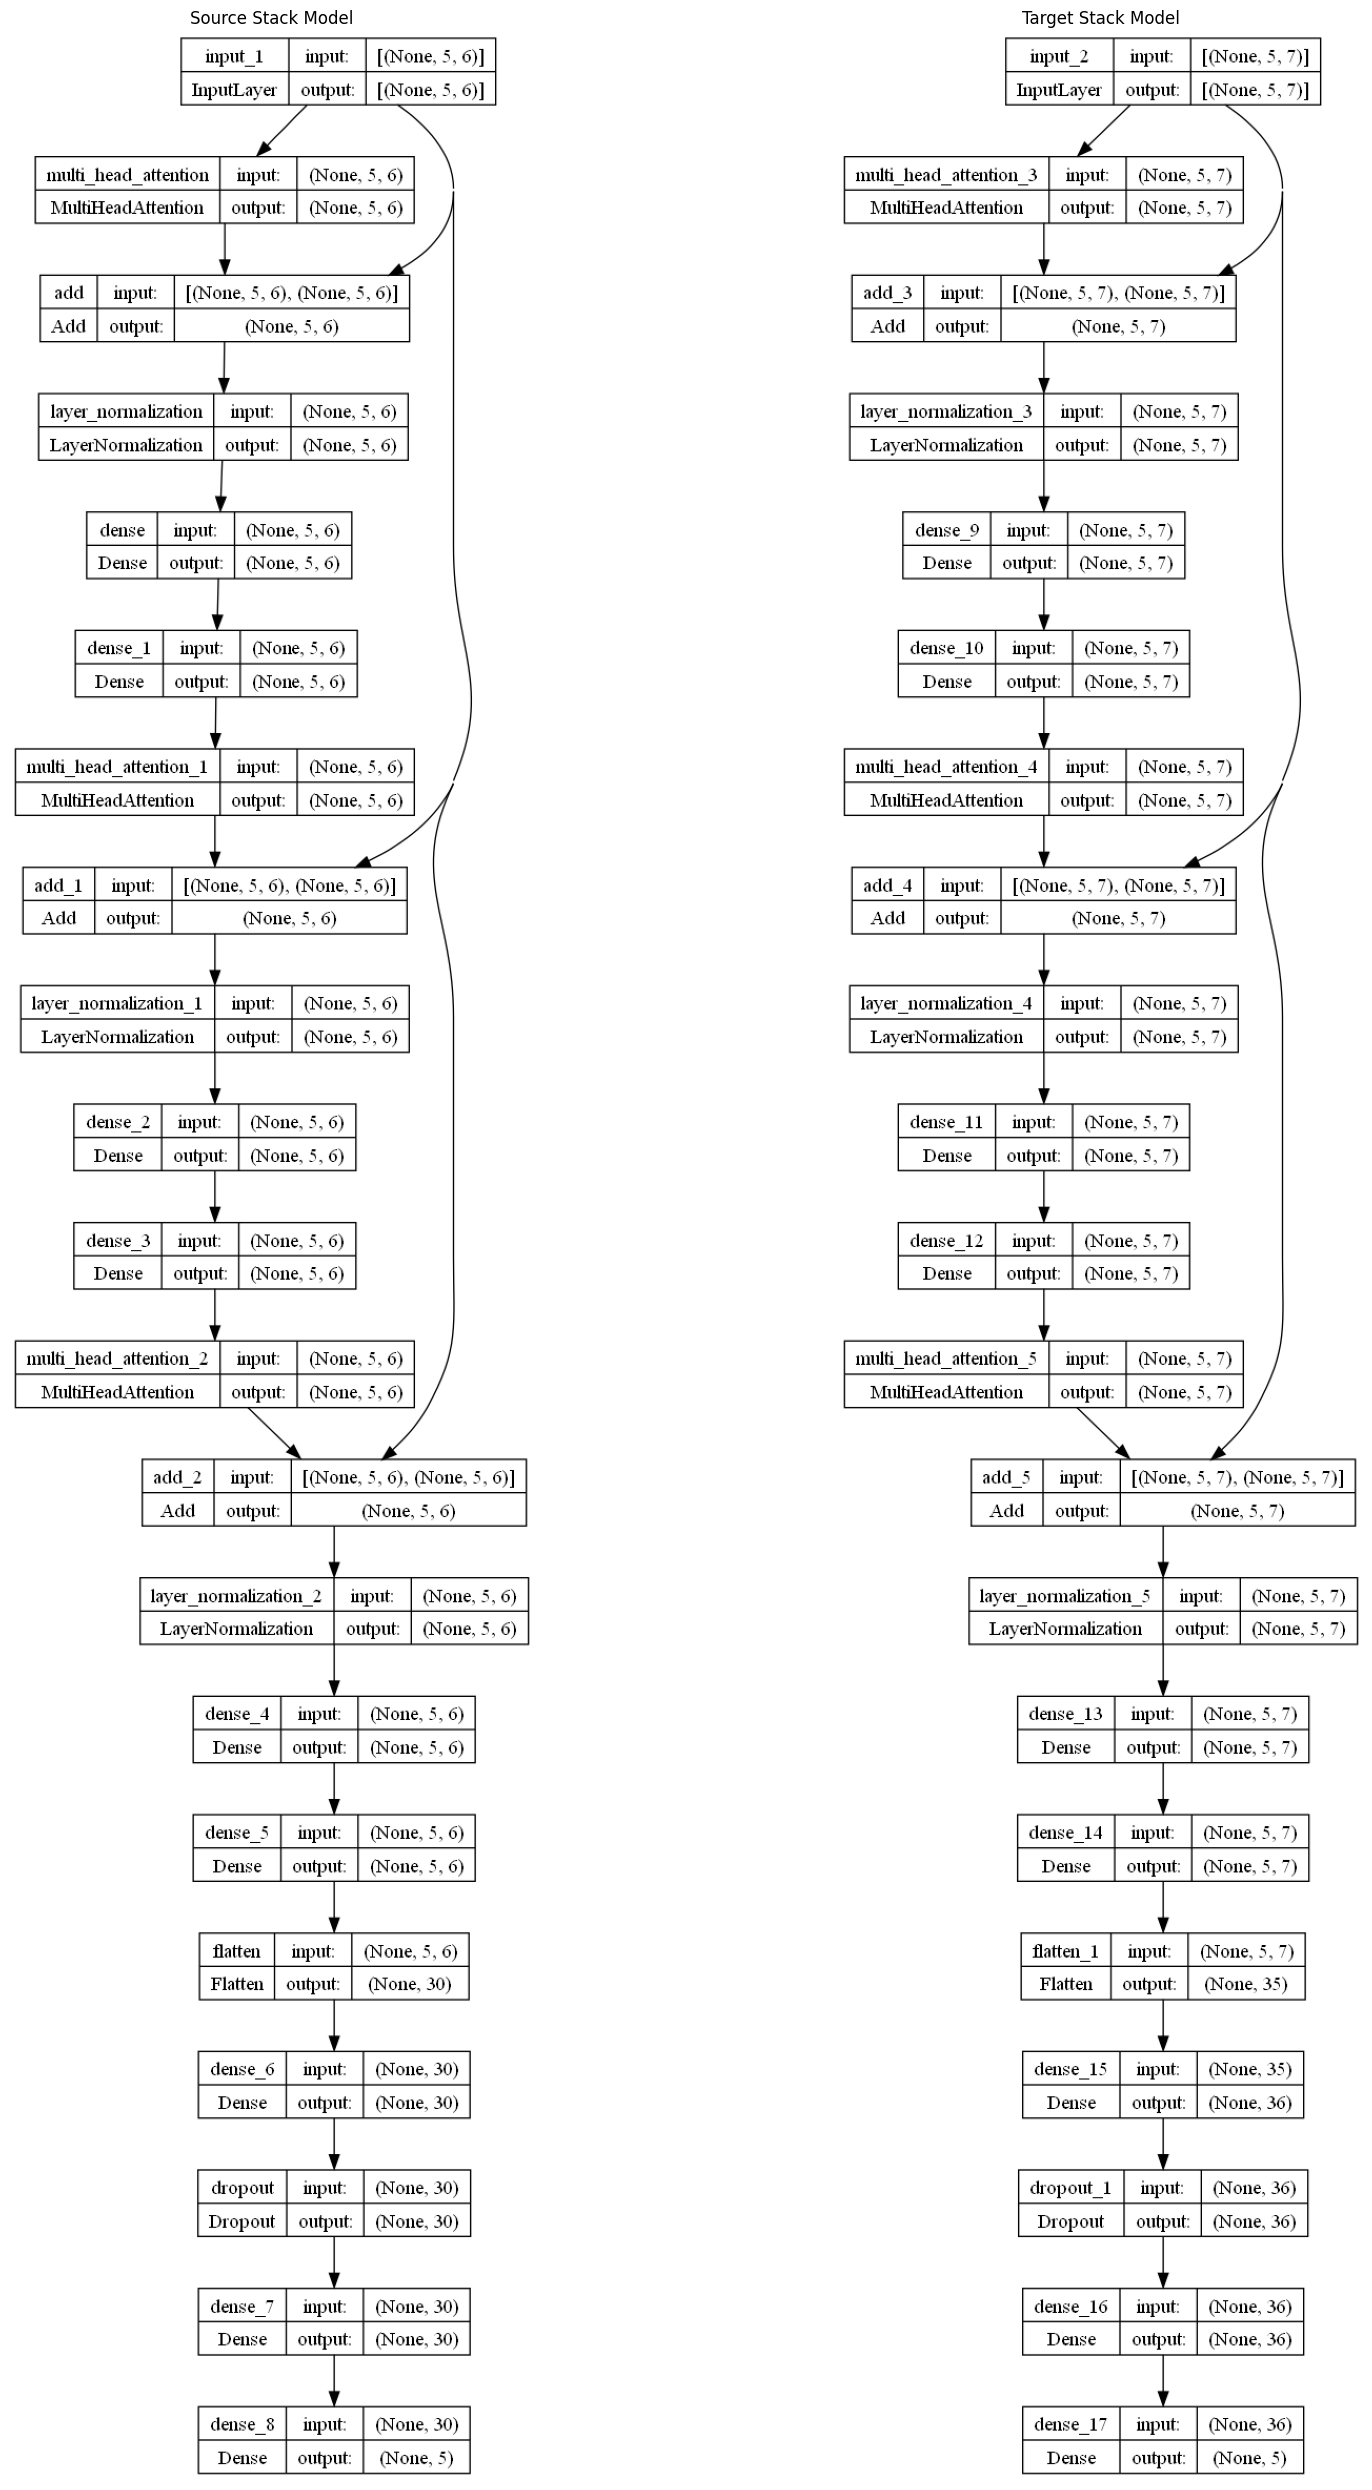

In [10]:
model_5x5_multi.plot_model(name= 'images_models/model_cpmp_multi')

## Entrenamiento